# MNIST Dataset: Error Detection

In [1]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from keras import backend as K
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imsave
import numpy as np
import time
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn import decomposition, svm
from sklearn import metrics
import warnings

# choose GPUs
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())




#custom libraries
#base_dir = '/Users/cyrilwendl/Documents/EPFL'
base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Zurich') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package

from density_tree.density_forest import *
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *
from baselines.helpers import *
from baselines.plots import *
from helpers.data_augment import *
from helpers.helpers import *
from helpers.plots import *
from parametric_tSNE.core import *
from parametric_tSNE.utils import *

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1530434597998571754
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10974989517
locality {
  bus_id: 1
}
incarnation: 7908392046494288239
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


# Data Import 
Import the data, delete all data in the training set of class 7


In [2]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train, y_train_label), (x_test, y_test_label) = mnist.load_data()

In [3]:
batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train_label, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test_label, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False;
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('mnist_models/mnist-weights.h5')
else :
    model = load_model('mnist_models/mnist-weights.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Make some predictions

In [5]:
y_pred_te = model.predict(x_test)
y_pred_label_te = get_y_pred_labels(y_pred_te, background=False)

In [6]:
c = get_acc_net_max_margin(y_pred_te)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

pred_acc_high = .95 # 95 % is considered a very high confidence

pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 99.06 %
Std accuracy: 7.08 %
97.47% of all predictions made with an accuracy higher than 0.95%


# Network
MSR, Margin, Entropy

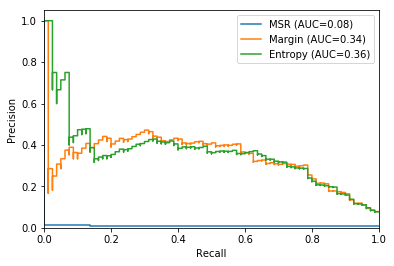

In [7]:
# precision-recall curves

# msr
y_scores = 1-get_acc_net_msr(y_pred_te)
y_true = (y_pred_label_te != y_test_label)*1
precision_msr, recall_msr, thresholds = metrics.precision_recall_curve(y_true, y_scores)
roc_auc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = 1-get_acc_net_max_margin(y_pred_te)
precision_margin, recall_margin, thresholds = metrics.precision_recall_curve(y_true, y_scores)
roc_auc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = 1-get_acc_net_entropy(y_pred_te)
precision_entropy, recall_entropy, thresholds = metrics.precision_recall_curve(y_true, y_scores)
roc_auc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)

# plot
plt.step(recall_msr, precision_msr, where='post')
plt.step(recall_margin,precision_margin, where='post')
plt.step(recall_entropy, precision_entropy, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('MSR (AUC=%.2f)'%(metrics.auc(recall_msr, precision_msr))),
            str.format('Margin (AUC=%.2f)'%(metrics.auc(recall_margin, precision_margin))),
            str.format('Entropy (AUC=%.2f)'%(metrics.auc(recall_entropy, precision_entropy)))])

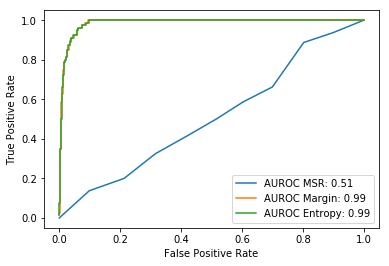

In [8]:
# ROC
plt.plot(fpr_msr,tpr_msr)
plt.plot(fpr_margin,tpr_margin)
plt.plot(fpr_entropy,tpr_entropy)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([str.format('AUROC MSR: %.2f') % roc_auc_msr,
            str.format('AUROC Margin: %.2f') % roc_auc_margin,
            str.format('AUROC Entropy: %.2f') % roc_auc_entropy
           ])

# Dropout

In [9]:
y_preds = predict_with_dropouts_batch(model, x_test, 
                                      batch_size=100, n_iter=100)

100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


In [10]:
y_pred = np.mean(y_preds, axis=0)
probas = get_acc_net_entropy(y_pred)

0.3315053033453573


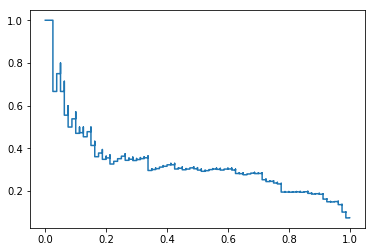

In [11]:
# precision-recall curve
y_scores = -probas
precision_dropout, recall_dropout, thresholds = metrics.precision_recall_curve(y_true, y_scores)
plt.step(recall_dropout,precision_dropout)
print(metrics.auc(recall_dropout, precision_dropout))
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, y_scores)
roc_auc_dropout = metrics.roc_auc_score(y_true, y_scores)

# Image Transformations

In [12]:
# TODO implement

## Get Activations, PCA, t-SNE

In [13]:
y_pred_tr = model.predict(x_train)
y_pred_label_tr = get_y_pred_labels(y_pred_tr, background=False)

In [14]:
pred_f_tr = np.where(y_pred_label_tr != y_train_label)[0]
pred_t_tr = np.where(y_pred_label_tr == y_train_label)[0]

pred_f_te = np.where(y_pred_label_te != y_test_label)[0]
pred_t_te = np.where(y_pred_label_te == y_test_label)[0]

In [15]:
# get activations of last layer
n_points = 10000
act_train = get_activations(model, 6, x_train[pred_t_tr][:n_points])[0]
print(np.shape(act_train))

act_test = get_activations(model, 6, x_test)[0]
print(np.shape(act_test))

(10000, 128)
(10000, 128)


In [16]:
pts_per_class = 300
n_classes=10
dataset_subset_indices = get_balanced_subset_indices(y_test_label, np.arange(n_classes), pts_per_class)

In [17]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
# t-SNE visualization after PCA
#tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

In [18]:
# color scale and legend for t-sne plots
colors = plt.cm.rainbow(np.linspace(0,1,n_classes))[:,:3]
names = ['Class '+str(i) for i in range(10)]
classes_to_keep = np.unique(y_test_label)

# plot
tsne_y = y_test_label[np.concatenate(dataset_subset_indices)]

Variance explained by first 15 components: 0.84


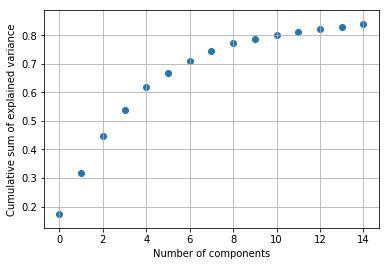

In [19]:
# PCA
n_components = 15
pca = decomposition.PCA(n_components=n_components)
pca.fit(act_train)

# plot
print("Variance explained by first %i components: %.2f" % (n_components, np.sum(pca.explained_variance_ratio_[:n_components])))
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.savefig("../Figures/DF/pca_components.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [20]:
X_train = pca.transform(act_train)
pca.fit(act_train)
X_test = pca.transform(act_test)

#### Visualize PCA

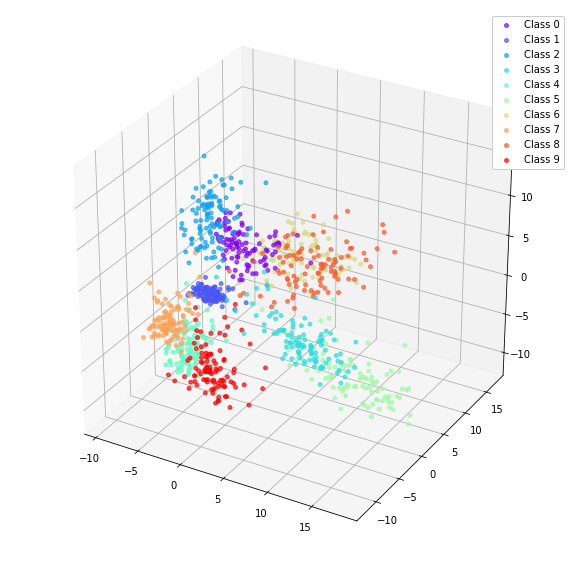

In [21]:
# test sample (with unseen class)
plot_pts_3d(X_test, y_test_label, classes_to_keep, names, colors, subsample_pct=.1)

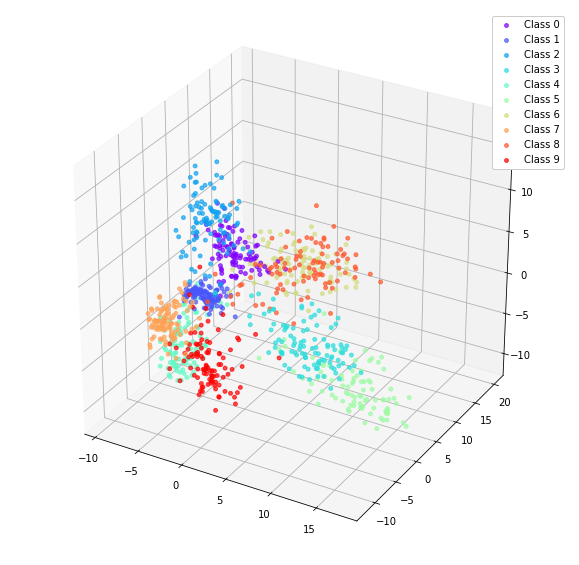

In [22]:
# training sample (without unseen class)
y_pca = y_train_label[pred_t_tr][:n_points]
plot_pts_3d(X_train, y_pca, classes_to_keep, names, colors, subsample_pct=.1)

In [23]:
# t-SNE visualization after PCA
%time tsne_all = tsne.fit_transform(X_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 1.016s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.451862
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.552658
[t-SNE] Error after 300 iterations: 2.656553
CPU times: user 1min 5s, sys: 38.5

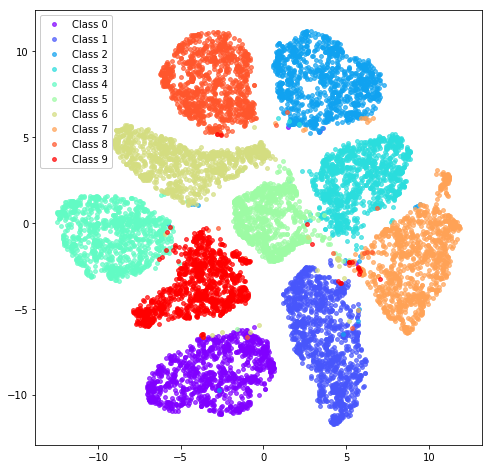

In [24]:
# plot
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_pts_2d(tsne_all, y_test_label, ax, classes_to_keep, names,
           colors, subsample_pct=1)

### GMM
GMM, calculate 

In [25]:
gmm = GaussianMixture(n_components=len(classes_to_keep), max_iter=10000)

In [26]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

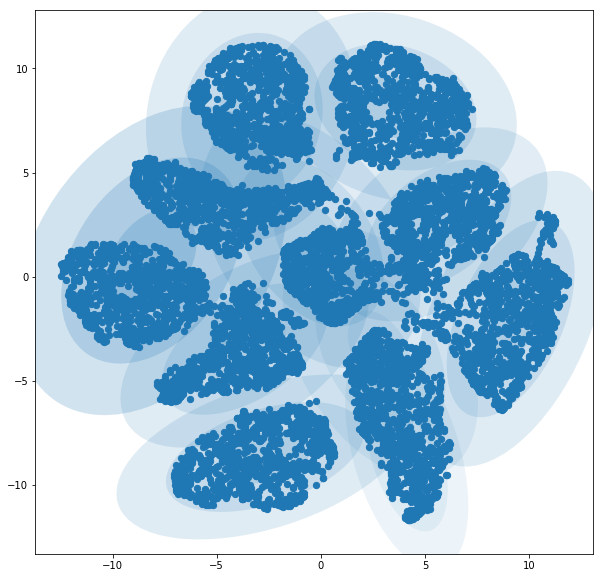

In [27]:
fig, axes = plt.subplots(1,1,figsize=(10,10)) 
plot_gmm(gmm, tsne_all, label=False, ax=axes)

In [28]:
gmm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=10000,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [29]:
probas = gmm.predict_proba(X_test)
probas = get_acc_net_entropy(probas)

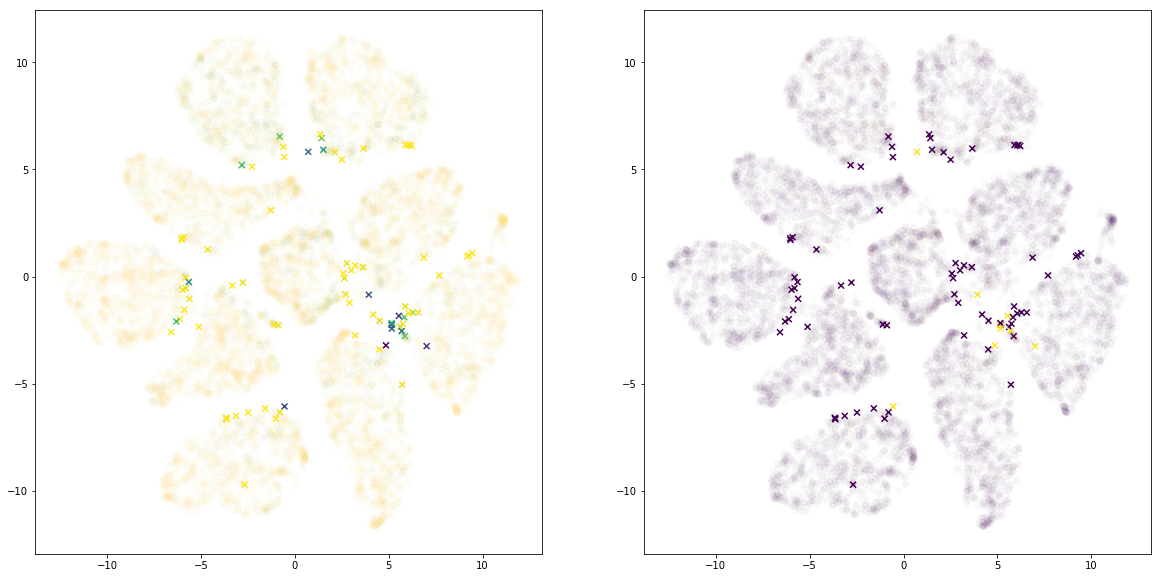

In [30]:
fig, axes = plt.subplots(1,2,figsize=(20,10)) 
# false predictions
axes[0].scatter(tsne_all[:,0][pred_f_te],tsne_all[:,1][pred_f_te],c=probas[pred_f_te], marker='x') # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_f_te],tsne_all[:,1][pred_f_te],c=(probas<np.sort(probas)[300])[pred_f_te], marker='x')  # 300 least certain points in yellow

# true predictions
axes[0].scatter(tsne_all[:,0][pred_t_te],tsne_all[:,1][pred_t_te],c=probas[pred_t_te] ,alpha=.02) # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_t_te],tsne_all[:,1][pred_t_te],c=(probas<np.sort(probas[pred_t_te])[300])[pred_t_te],alpha=.02)  # 300 least certain points in yellow

In [31]:
# make prodictions for class unseen during training
y_pred = model.predict(x_test)
y_pred_label = get_y_pred_labels(y_pred, background=False)

In [32]:
def df_traverse(dataset, root_nodes, thresh=.1, method='normal', standardize=False):
    """
    traverse Density Forest (DF) and get mean probability for point to belong to the leaf clusters of each tree
    :param dataset: dataset for which to traverse DF
    :param root_nodes: Array of root nodes belonging to a DF
    :param thresh:
    :param method:
    :param standardize:
    :return:
    """
    # set up variabless
    pairs_proba = np.empty((len(dataset), len(root_nodes)), float)  # indexes of data points

    # get all clusters for all points in all trees
    for d_idx, d in enumerate(dataset):
        # traverse all trees
        for t_idx, tree in enumerate(root_nodes):
            d_mean, d_pct, d_pdf_mean, d_cov_det, d_cov_inv = descend_density_tree(d, tree)
            if d_pct > thresh:
                if method == 'normal':
                    pairs_proba[d_idx, t_idx] = d_pct * my_normal(d, d_mean, d_cov_det, d_cov_inv)
                    if standardize:
                        pairs_proba[d_idx, t_idx] /= d_pdf_mean  # standardize by max. probability
                else:
                    pairs_proba[d_idx, t_idx] = euclidean(d_mean, d)
                    if standardize:
                        pairs_proba[d_idx, t_idx] /= d_pdf_mean  # standardize by max. probability
            else:
                pairs_proba[d_idx, t_idx] = np.nan

    return np.nanmean(pairs_proba, axis=-1)

0.015138129207562983

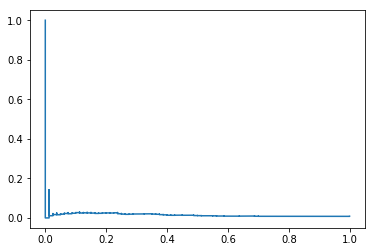

In [33]:
# precision-recall curve
y_scores = -probas
precision_gmm, recall_gmm, thresholds = metrics.precision_recall_curve(y_true, y_scores)
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, y_scores)
roc_auc_gmm = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_gmm, precision_gmm)
metrics.auc(recall_gmm, precision_gmm)

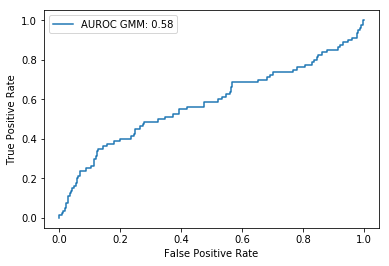

In [34]:
# ROC
plt.plot(fpr_gmm, tpr_gmm)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([str.format('AUROC GMM: %.2f') % roc_auc_gmm])

## Novelty Detection on Activations:
- One-class SVM
- Isolation Forest

### One-class SVM

In [35]:
clf_svm = svm.OneClassSVM(kernel='poly', degree=10, nu=.04)

In [36]:
clf_svm.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=10, gamma='auto', kernel='poly',
      max_iter=-1, nu=0.04, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [37]:
probas = clf_svm.decision_function(X_test)
probas -= np.min(probas)
probas /= np.max(probas)

In [38]:
#predict
probas = clf_svm.predict(X_test)

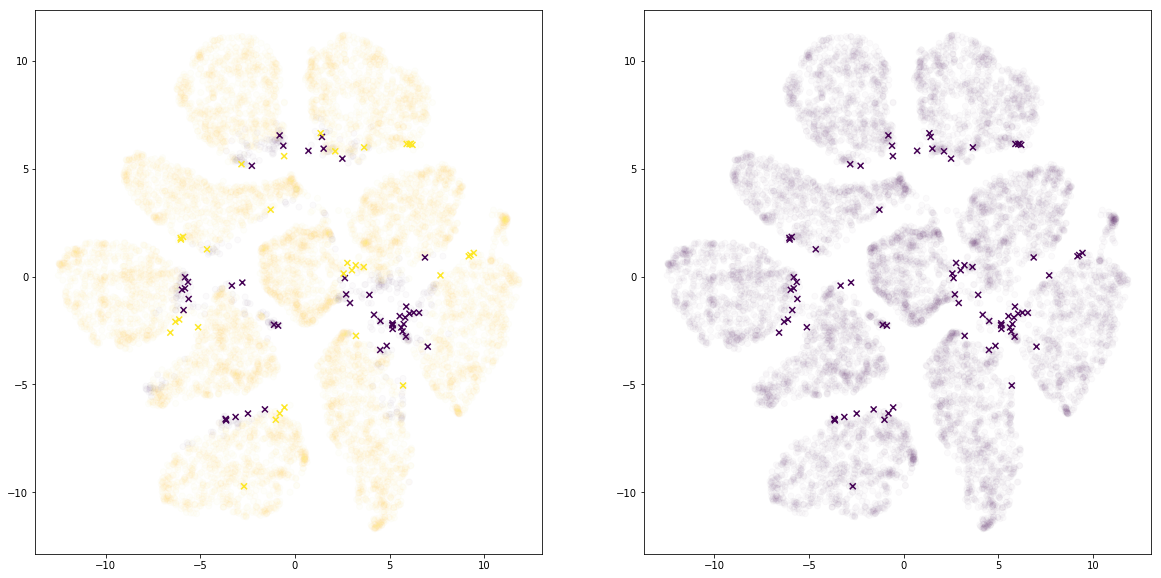

In [39]:
# plot correctly predicted points (x marker)
# plot correctly predicted points (o marker)
fig, axes = plt.subplots(1,2,figsize=(20,10)) 
axes[0].scatter(tsne_all[:,0][pred_t_te],tsne_all[:,1][pred_t_te], c=probas[pred_t_te], alpha=.02) # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_t_te],tsne_all[:,1][pred_t_te], c=(probas<np.sort(probas)[300])[pred_t_te], alpha=.02)  # 300 least certain points in yellow

# plot correctly predicted points (x marker)
# plot correctly predicted points (o marker)
axes[0].scatter(tsne_all[:,0][pred_f_te],tsne_all[:,1][pred_f_te],c=probas[pred_f_te], marker='x') # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_f_te],tsne_all[:,1][pred_f_te],c=(probas<np.sort(probas)[300])[pred_f_te], marker='x')  # 300 least certain points in yellow

0.3357780068728522

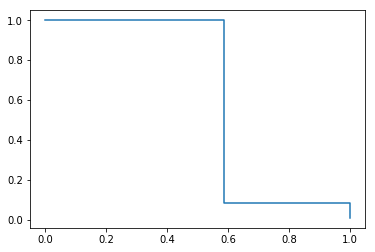

In [40]:
# precision-recall curve
y_scores = -probas
precision_svm, recall_svm, thresholds = metrics.precision_recall_curve(y_true, y_scores)
plt.step(recall_svm, precision_svm)
metrics.auc(recall_svm, precision_svm)

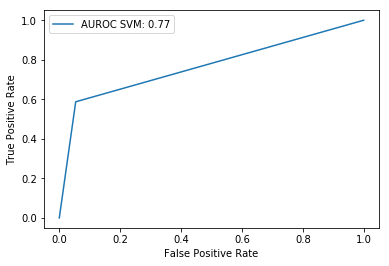

In [41]:
# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, y_scores)
roc_auc_svm = metrics.roc_auc_score(y_true, y_scores)
plt.plot(fpr_svm, tpr_svm)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([str.format('AUROC SVM: %.2f') % roc_auc_svm])

# Density Forest

In [42]:
root_nodes = df_create(X_train, max_depth=5, min_subset=.1, n_trees=10, subsample_pct=.1, 
          n_max_dim=0, n_jobs=-1, verbose=1, fact_improvement=.1)

Number of points on which to train each tree: 1000
Minimum number of points in each leaf: 100


[Parallel(n_jobs=40)]: Done   8 out of  10 | elapsed:    8.4s remaining:    2.1s


Number of created root nodes: 10
Mean number of clusters created per tree: 14


[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:    8.7s finished


In [43]:
probas = df_traverse(X_test, root_nodes, thresh=0)

0.017118673973577827

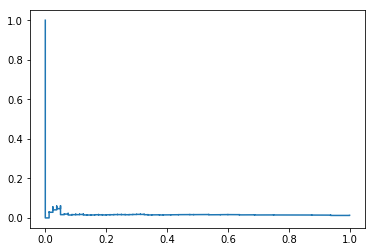

In [44]:
# precision-recall curve
y_scores = -probas
precision_df, recall_df, thresholds = metrics.precision_recall_curve(y_true, y_scores)
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
roc_auc_df = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_df, precision_df)
metrics.auc(recall_df, precision_df)

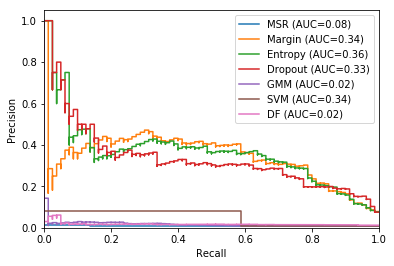

In [45]:
# plot
plt.step(recall_msr, precision_msr, where='post')
plt.step(recall_margin,precision_margin, where='post')
plt.step(recall_entropy, precision_entropy, where='post')
plt.step(recall_dropout, precision_dropout, where='post')
plt.step(recall_gmm, precision_gmm, where='post')
plt.step(recall_svm, precision_svm, where='post')
plt.step(recall_df, precision_df, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('MSR (AUC=%.2f)'%(metrics.auc(recall_msr, precision_msr))),
            str.format('Margin (AUC=%.2f)'%(metrics.auc(recall_margin, precision_margin))),
            str.format('Entropy (AUC=%.2f)'%(metrics.auc(recall_entropy, precision_entropy))),
            str.format('Dropout (AUC=%.2f)'%(metrics.auc(recall_dropout, precision_dropout))),
            str.format('GMM (AUC=%.2f)'%(metrics.auc(recall_gmm, precision_gmm))),
            str.format('SVM (AUC=%.2f)'%(metrics.auc(recall_svm, precision_svm))),
            str.format('DF (AUC=%.2f)'%(metrics.auc(recall_df, precision_df)))
           ])

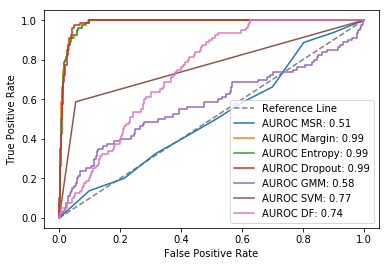

In [48]:
# ROC
plt.plot([0,1],[0,1], '--', c='gray')
plt.plot(fpr_msr,tpr_msr)
plt.plot(fpr_margin,tpr_margin)
plt.plot(fpr_entropy,tpr_entropy)
plt.plot(fpr_dropout,tpr_dropout)
plt.plot(fpr_gmm,tpr_gmm)
plt.plot(fpr_svm,tpr_svm)
plt.plot(fpr_df,tpr_df)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Reference Line',
            str.format('AUROC MSR: %.2f') % roc_auc_msr,
            str.format('AUROC Margin: %.2f') % roc_auc_margin,
            str.format('AUROC Entropy: %.2f') % roc_auc_entropy,
            str.format('AUROC Dropout: %.2f') % roc_auc_dropout,
            str.format('AUROC GMM: %.2f') % roc_auc_gmm,
            str.format('AUROC SVM: %.2f') % roc_auc_svm,
            str.format('AUROC DF: %.2f') % roc_auc_df
           ])